In [ ]:
import os 
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max
import skimage as ski

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
from network_flow_tracker import LFBFP
import network_flow_tracker.utils.io as io
import network_flow_tracker.utils.vis as vis
import network_flow_tracker.utils.image as im
import network_flow_tracker.utils.neighbors as nb
import network_flow_tracker.utils.stat as stat

### Loading data

In [3]:
data_root_path = 'C:\\Data\\Lightfield\\Zhang2020'
server_root_path = data_root_path
process_data_root = os.path.join(data_root_path, 'processed_data')
info_fp = os.path.join(process_data_root, 'data_info.pickle')
data_info = io.load_data(info_fp)
lfp = LFBFP.LFBFProcessing(data_root_path, data_info)

In [7]:
z_idx = 0
t_idx = 0

In [8]:
# Load mip 
mip_fp = os.path.join(server_root_path, 'processed_data', 'mip', 'raw', f"{data_info['raw_data_folders'][z_idx]}_raw.tif")
vsl_im = lfp.load_and_preprocess_raw_data_to_match_mask(fp=mip_fp)
vsl_mip = LFBFP.Visualization.compute_mip_for_vis(vsl_im)
print(f"Finish loading {mip_fp}")

Finish loading C:\Data\Lightfield\Zhang2020\processed_data\mip\raw\z0_150um_raw.tif


# Single frame test

In [15]:
import network_flow_tracker.utils.filters as imf

In [9]:
test_data = lfp.load_and_preprocess_raw_data_to_match_mask(z_idx, t_idx) # (75, 400, 400), circular masked
vis_mip = im.stretch_contrast(np.max(test_data, axis=0), saturate_ptl_high=99.95)

In [10]:
para = {}
para['dog_sig1'] = 0
para['dog_sig2'] = (2, 2, 2)
para['bg_vxl_f'] = 0.95
para['bg_est_sample_step'] = 10
para['min_peak_snr'] = 5
para['bg_max_int'] = 500
para['min_peak_dist'] = 3
para['peak_int_diff_sm_wd'] = 10
para['peak_int_diff_th'] = 1
para['nb_wd_r'] = (2, 2, 2)
para['nb_bg_min_dist'] = np.sqrt(5)

In [11]:
# Integrated 
nb_features, info = LFBFP.Detection.process_single_volume(test_data, para)
nb_features['info'] = info | para

In [12]:
data_fp = lfp.fp_cell_pos(z_idx, t_idx)
data_fp

'C:\\Data\\Lightfield\\Zhang2020\\processed_data\\cell_pos\\z0_150um\\00001.h5'

In [189]:
io.save_h5(data_fp, nb_features)

In [13]:
tmp_data = io.load_data(data_fp)

### Debug

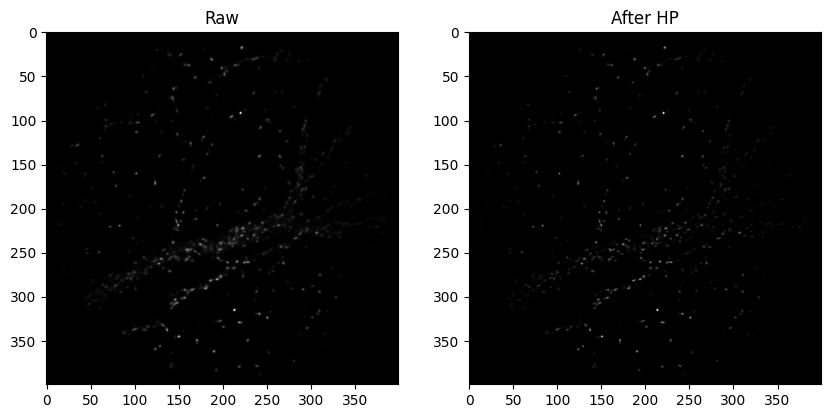

In [16]:
debug_Q = True
gf_sigma = (2, 2, 2) # kernel size = 2r + 1 = 8 sigma + 1
data_hp = imf.dog(test_data.astype(np.float32), 0, gf_sigma)
data_hp = np.maximum(data_hp, 0)

if debug_Q:
    test_data_mip = np.max(test_data, axis=0)
    data_hp_max = np.max(data_hp, axis=0)
    # Comparing mip before vs after high pass filter
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(test_data_mip, cmap='gray')
    ax[0].set_title('Raw')
    ax[1].imshow(data_hp_max, cmap='gray')
    ax[1].set_title('After HP')

In [59]:
est_bg_ptl = 0.95
sample_step = 10 # secondary
est_peak_min_snr = 5
est_max_int = 500
# Peak detection
min_dist = 3

mov_wd_len = 10
min_int_diff = 1

sample_wd_r = np.array([2, 2, 2])
min_bg_dist = np.sqrt(5)
im_vol = test_data

In [60]:
# It seems that high-pass-filtering improves peak detection
valid_lm_ind, info = LFBFP.Detection.detect_local_maxima(data_hp, est_bg_ptl, est_max_int, est_peak_min_snr, min_dist, mov_wd_len)
# Which volume should be used for computing the features? Raw or high-pass-filtered?
nb_features = LFBFP.Detection.compute_features(valid_lm_ind, im_vol, sample_wd_r, min_bg_dist)

In [61]:
# Estimate background level 
circ_mask = LFBFP.Utility.construct_circular_mask(test_data.shape[1:3])
circ_mask = np.repeat(circ_mask[None, :, :], test_data.shape[0], axis=0)
bg_info = stat.estimate_background_by_fraction(data_hp, est_bg_ptl, sample_step, circ_mask)
est_th = min(est_max_int, bg_info['mean'] + bg_info['std'] * est_peak_min_snr)


# By excluding the border, the local max won't be on the border - easier for querying the neighbors
local_max_pos = peak_local_max(data_hp, min_distance=min_dist, threshold_abs=est_th, exclude_border=False)
local_max_pos = local_max_pos.transpose()
local_max_ind = np.ravel_multi_index((local_max_pos[0], local_max_pos[1], local_max_pos[2]), data_hp.shape)
if debug_Q:
    print(f"Detect {local_max_pos.shape[1]} local maxima")

# Select local maxima
# sort intensity in desending order
local_max_int = data_hp.flat[local_max_ind]
local_max_int_idx = np.argsort(local_max_int)[::-1]
local_max_int = local_max_int[local_max_int_idx]

local_max_int_d = - np.diff(local_max_int)
local_max_int_d_sm = np.convolve(local_max_int_d, np.ones(mov_wd_len) / mov_wd_len, 'same')
num_local_max = np.nonzero(local_max_int_d_sm < min_int_diff)[0][0] # Get the first 

valid_lm_ind = local_max_ind[local_max_int_idx[0:num_local_max]]
valid_lm_sub = np.unravel_index(valid_lm_ind, data_hp.shape)
print(f"Number of valid local maximia is {num_local_max}")

Detect 9115 local maxima
Number of valid local maximia is 675


In [62]:
sample_wd_r = np.array([2, 2, 2])
min_bg_dist = np.sqrt(5)
im_vol = test_data
nb_features = LFBFP.Detection.compute_features(valid_lm_ind, im_vol, sample_wd_r, min_bg_dist)

In [63]:
sample_wd_d = 2 * sample_wd_r + 1
# For each peak, compute features
sample_kernel = np.ones(sample_wd_d, bool)
dind, dsub = nb.compute_kernel_offset_pos_and_ind_in_padded_mask(sample_kernel, im_vol.shape)

valid_lm_int = im_vol.flat[valid_lm_ind]
dsub_a = np.vstack(dsub)
# dsub_a = np.vstack([s.flatten() for s in dsub])
dist = np.sqrt(np.sum(dsub_a ** 2, axis=0))

# sample_bg_mask = np.any(np.abs(dsub_a) > 1, axis=0) 
sample_bg_mask = dist >= np.sqrt(min_bg_dist)

In [64]:
im_vol_pad = np.pad(im_vol, ((sample_wd_r[0], sample_wd_r[0]), (sample_wd_r[1], sample_wd_r[1]), (sample_wd_r[2], sample_wd_r[2])))
valid_lm_ind_p = nb.compute_voxel_offseted_linear_indices(valid_lm_ind, im_vol.shape, sample_wd_r)

In [65]:
# debug - single 
tmp_p_idx = 0
tmp_ind = valid_lm_ind_p[tmp_p_idx] + dind.flatten()
tmp_int = im_vol_pad.flat[tmp_ind]
# print(f"Neighboring intensity profile:\n {tmp_int.reshape(sample_wd_d)}")
tmp_com = np.sum(dsub_a * tmp_int[None, :], axis=1) / tmp_int.sum()
tmp_dev = dsub_a - tmp_com[:, None]
tmp_cov = np.dot(tmp_dev * tmp_int, tmp_dev.T) / tmp_int.sum()
tmp_cov_e, tmp_cov_v = np.linalg.eigh(tmp_cov)
print(f"COM:\n {tmp_com}")
print(f"Covariance matrix:\n {tmp_cov}")
print(f"eigenvalue: {tmp_cov_e}\neigenvector:\n{tmp_cov_v}")

COM:
 [-0.10746394  0.35454983  0.04596419]
Covariance matrix:
 [[ 1.49055971  0.06179349  0.05150516]
 [ 0.06179349  0.76050436 -0.06886412]
 [ 0.05150516 -0.06886412  0.70057677]]
eigenvalue: [0.64837957 0.80488317 1.4983781 ]
eigenvector:
[[-0.09135981  0.03230581 -0.99529379]
 [ 0.55723552 -0.82668451 -0.07798265]
 [ 0.82531325  0.56173753 -0.0575238 ]]


In [ ]:
# debug vectorized
lm_pos = np.vstack(valid_lm_sub) + tmp_com.transpose()

tmp_p_idx = np.arange(valid_lm_ind_p.size)
tmp_ind = valid_lm_ind_p[tmp_p_idx][:, None] + dind.flatten()[None, :]
tmp_int = im_vol_pad.flat[tmp_ind].astype(np.float32) # (n, nb)
tmp_bg_int = tmp_int[:, sample_bg_mask]
tmp_bg_mean = np.mean(tmp_bg_int, axis=1)
tmp_bg_std = np.std(tmp_bg_int, axis=1)
tmp_peak_snr = (valid_lm_int - tmp_bg_mean) / tmp_bg_std

tmp_int /= np.sum(tmp_int, axis=1)[:, None]
tmp_com = np.sum(dsub_a[None, :, :] * tmp_int[:, None, :], axis=2)# (n, 3)
tmp_dev = dsub_a[None, :, :] - tmp_com[:, :, None] # (n, 3, nb)
tmp_cov = np.einsum('nil,njl->nij', tmp_dev * tmp_int[:, None, :], tmp_dev) # (n, 3, nb) x (n, 3, nb) -> (n, 3, 3)
tmp_eig, tmp_eigv = np.linalg.eigh(tmp_cov)
tmp_eigv_1 = tmp_eigv[:, :, -1]

### Visualization

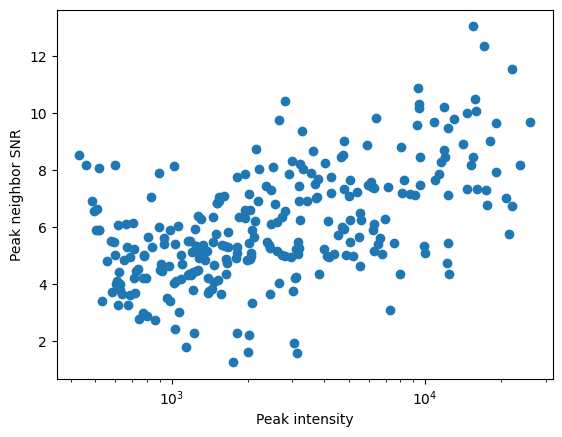

In [15]:
valid_lm_int = nb_features['peak_int']
tmp_peak_snr = nb_features['peak_nb_snr']

plt.close('all')
fig, ax = plt.subplots()
ax.scatter(valid_lm_int, tmp_peak_snr)
ax.set_xlabel("Peak intensity")
ax.set_ylabel("Peak neighbor SNR")
ax.set_xscale('log')

In [ ]:
vis_Q = tmp_peak_snr > 2
vis_sub = (nb_features['pos'][vis_Q, 0], nb_features['pos'][vis_Q, 1], nb_features['pos'][vis_Q, 2])
vis_snr = tmp_peak_snr[vis_Q]

In [ ]:
fig, ax = LFBFP.Detection.vis_detected_centroid(vis_mip, vis_sub, c_val=vis_snr, mip_t=vsl_mip, figsize=(12, 8))

# Deploy

In [205]:
tmp = LFBFP.dist_compute_single_stack_cell_positions(data_root_path, z_idx, t_idx, para, True, False)

In [3]:
data_root_path = '/scratch/Vessel/Lightfield/Zhang2020'
process_data_root = os.path.join(data_root_path, 'processed_data')
info_fp = os.path.join(process_data_root, 'data_info.pickle')
data_info = io.load_data(info_fp)

In [4]:
para = {}
para['dog_sig1'] = 0
para['dog_sig2'] = (2, 2, 2)
para['bg_vxl_f'] = 0.95
para['bg_est_sample_step'] = 10
para['min_peak_snr'] = 5
para['bg_max_int'] = 500
para['min_peak_dist'] = 3
para['peak_int_diff_sm_wd'] = 10
para['peak_int_diff_th'] = 1
para['nb_wd_r'] = (2, 2, 2)
para['nb_bg_min_dist'] = np.sqrt(5)

In [5]:
# 21.7 minutes for all the data
for z_idx in range(data_info['num_z']):
    args = [(data_root_path, z_idx, t_idx, para, True, False) for t_idx in range(data_info['num_files'][z_idx])]
    with Pool(int(os.cpu_count()/2)) as p: 
        result = p.starmap(LFBFP.dist_compute_single_stack_cell_positions, args)
    print("Finish computing all the task")   

Finish computing all the task
Finish computing all the task
Finish computing all the task
Finish computing all the task
Finish computing all the task
Finish computing all the task
